In [253]:
'Test_Task2_With or without baby Detection using RanFor model and SVM model'

'Test_Task2_With or without baby Detection using RanFor model and SVM model'

In [254]:
import gc
gc.collect()

14

In [255]:
%reset -f

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

# Test Measurements

In [257]:
import os
import numpy as np
import pandas as pd

# Define path (2 levels up -> Data/Processed)
file_path = os.path.join("..", "..", "Data", "Processed", "CarrierSeat_withoutBaby_Lowpassfilered_Label_0.npy")

# Load the NumPy array from the file
loaded_array = np.load(file_path, mmap_mode='r')

# Convert to DataFrame
dataframe_testdata = pd.DataFrame(
    loaded_array,
    columns=['Frequency', 'FFT Magnitude', 'Phase', 'Infant_Presence']
)

# Take first 2000 rows (or use sampling instead if needed)
dataframe_testdata = dataframe_testdata.iloc[:2000]
# dataframe_testdata = dataframe_testdata.sample(n=2000, random_state=42)

print(f"Data loaded from: {os.path.abspath(file_path)}")
dataframe_testdata

Data loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Data/Processed/CarrierSeat_withoutBaby_Lowpassfilered_Label_0.npy


,Frequency,FFT Magnitude,Phase,Infant_Presence
0,0.000,104749.366658,0.000000,0.0
1,78.125,52421.282760,-3.130457,0.0
2,156.250,2858.080997,1.630063,0.0
3,234.375,2785.146203,-0.997409,0.0
4,312.500,1836.985949,2.804369,0.0
...,...,...,...,...
1995,155859.375,1593.463658,2.052034,0.0
1996,155937.500,867.149039,-1.614056,0.0
1997,156015.625,447.175561,-0.331831,0.0
1998,156093.750,462.384006,2.885224,0.0


In [258]:
num_rows_test = len(dataframe_testdata)
num_rows_test

2000

In [259]:
fft_magnitudes_test = dataframe_testdata["FFT Magnitude"].values  # Convert to NumPy array
fft_magnitudes_test

array([104749.36665761,  52421.28276004,   2858.08099686, ...,
          447.17556066,    462.38400634,    681.57457988], shape=(2000,))

In [260]:
fft_frequencies_test = dataframe_testdata["Frequency"].values  # Convert to NumPy array
fft_frequencies_test

array([0.00000000e+00, 7.81250000e+01, 1.56250000e+02, ...,
       1.56015625e+05, 1.56093750e+05, 1.56171875e+05], shape=(2000,))

In [261]:
fft_phase_test = dataframe_testdata["Phase"].values  # Convert to NumPy array
fft_phase_test

array([ 0.        , -3.13045712,  1.6300633 , ..., -0.33183129,
        2.88522358,  0.70598984], shape=(2000,))

In [262]:
import numpy as np
from scipy.stats import entropy
from scipy.signal import find_peaks

def extract_features(fft_freqs, fft_mags, fft_phase):
    # Normalize magnitudes to prevent division errors
    norm_mags = fft_mags / np.sum(fft_mags) if np.sum(fft_mags) > 0 else fft_mags
    
    # Spectral Centroid (Weighted Mean of Frequencies)
    spectral_centroid = np.sum(fft_freqs * norm_mags) / np.sum(norm_mags)

    # Spectral Bandwidth (Spread around centroid)
    spectral_bandwidth = np.sqrt(np.sum(norm_mags * (fft_freqs - spectral_centroid) ** 2))

    # Spectral Flatness (Geometric Mean / Arithmetic Mean)
    spectral_flatness = np.exp(np.mean(np.log(fft_mags + 1e-10))) / np.mean(fft_mags + 1e-10)

    # Find peaks in the magnitude spectrum
    peaks, _ = find_peaks(fft_mags, height=0.1 * np.max(fft_mags))  # Adaptive threshold

    # Harmonic Ratio (Ratio of 2nd peak to 1st peak)
    if len(peaks) >= 2:
        harmonic_ratio = fft_mags[peaks[1]] / fft_mags[peaks[0]]
    else:
        harmonic_ratio = 0  # No second peak detected

    # Phase Features
    phase_variance = np.var(fft_phase)  # Variance of phase angles
    phase_mean = np.mean(fft_phase)  # Mean of phase angles
    phase_diff = np.mean(np.diff(fft_phase))  # Average phase difference between frequencies

    return {
        "mean_fft": np.mean(fft_mags),
        "std_fft": np.std(fft_mags),
        "max_fft": np.max(fft_mags),
        "min_fft": np.min(fft_mags),
        "median_fft": np.median(fft_mags),
        "sum_fft": np.sum(fft_mags),
        "spectral_entropy": entropy(norm_mags),  # Energy spread
        "spectral_centroid": spectral_centroid,
        "spectral_bandwidth": spectral_bandwidth,
        "spectral_flatness": spectral_flatness,
        "phase_variance": phase_variance,
        "phase_mean": phase_mean,
        "phase_diff": phase_diff,
    }

In [263]:
# Function to apply perturbation based on reference values
def add_perturbation(reference_features, num_rows, perturb_range=0.03):
    perturbed_data = []
    
    for _ in range(num_rows):
        perturbed_features = {
            key: value * (1 + np.random.uniform(-perturb_range, perturb_range)) 
            for key, value in reference_features.items()
        }
        perturbed_data.append(perturbed_features)
    
    return pd.DataFrame(perturbed_data)

In [264]:
# Extract features for fft_test
reference_features_test = extract_features(fft_frequencies_test, fft_magnitudes_test, fft_phase_test)
reference_features_test

{'mean_fft': np.float64(915.8702142992524),
 'std_fft': np.float64(2641.704753743293),
 'max_fft': np.float64(104749.36665761432),
 'min_fft': np.float64(0.9930308466425066),
 'median_fft': np.float64(741.4678771625448),
 'sum_fft': np.float64(1831740.428598505),
 'spectral_entropy': np.float64(7.136809174691093),
 'spectral_centroid': np.float64(64725.741214643764),
 'spectral_bandwidth': np.float64(45545.63935165247),
 'spectral_flatness': np.float64(0.7492610472047804),
 'phase_variance': np.float64(3.3049371648473924),
 'phase_mean': np.float64(-0.008210787923691202),
 'phase_diff': np.float64(0.00035317150426811804)}

In [265]:
# Generate a DataFrame with perturbed values for all rows in fft_test
num_rows_test = len(dataframe_testdata)
perturbed_test_df = add_perturbation(reference_features_test, num_rows_test, perturb_range=0.03)
perturbed_test_df

,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,spectral_flatness,phase_variance,phase_mean,phase_diff
0,910.595344,2648.152767,107190.071668,0.985147,762.129702,1.802774e+06,7.324246,63540.761758,45557.070903,0.754686,3.283376,-0.008199,0.000357
1,939.393948,2689.992654,102691.426116,1.010777,721.103143,1.833858e+06,7.145764,63009.994433,45702.080745,0.728054,3.265884,-0.008334,0.000361
2,928.934984,2700.227157,102970.205004,0.970172,747.431106,1.880621e+06,7.297004,65136.582265,45390.938565,0.769385,3.342250,-0.008100,0.000354
3,893.440763,2644.800661,106651.291000,0.997335,723.092112,1.808468e+06,7.219776,66283.554349,44194.790450,0.757068,3.207061,-0.008388,0.000362
4,901.601755,2635.898952,103902.252129,0.981576,719.999912,1.803124e+06,7.347328,65355.228809,46440.026037,0.764823,3.350456,-0.007978,0.000346
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,934.672762,2710.110986,103264.400011,0.974929,730.911394,1.783057e+06,7.210703,64268.956519,44447.137525,0.769985,3.353808,-0.008204,0.000353
1996,935.807972,2711.856916,105819.410892,1.002546,730.426317,1.824104e+06,7.266876,66270.484197,45441.938956,0.759551,3.218231,-0.008236,0.000361
1997,896.878551,2565.386269,104087.892702,0.992644,756.826908,1.848580e+06,7.054013,63741.416802,45053.747707,0.731534,3.238777,-0.007991,0.000355
1998,905.213787,2644.737775,104788.762411,1.007558,759.548695,1.781807e+06,7.103460,65594.710596,46564.495690,0.764818,3.358464,-0.008453,0.000345


In [266]:
dataframe_testdata

,Frequency,FFT Magnitude,Phase,Infant_Presence
0,0.000,104749.366658,0.000000,0.0
1,78.125,52421.282760,-3.130457,0.0
2,156.250,2858.080997,1.630063,0.0
3,234.375,2785.146203,-0.997409,0.0
4,312.500,1836.985949,2.804369,0.0
...,...,...,...,...
1995,155859.375,1593.463658,2.052034,0.0
1996,155937.500,867.149039,-1.614056,0.0
1997,156015.625,447.175561,-0.331831,0.0
1998,156093.750,462.384006,2.885224,0.0


In [267]:
len(perturbed_test_df),len(dataframe_testdata)

(2000, 2000)

In [268]:
# Ensure both DataFrames have the same number of rows
if len(dataframe_testdata) != len(perturbed_test_df):
    print("The DataFrames have different lengths. Adjust them to have the same number of rows before concatenating.")
else:
    # Concatenate the DataFrames side by side
    dataframe_testdata_withfeatures = pd.concat([dataframe_testdata, perturbed_test_df], axis=1)

# Display the first few rows of the updated dataframe_testdata to verify
dataframe_testdata_withfeatures.head()

,Frequency,FFT Magnitude,Phase,Infant_Presence,mean_fft,std_fft,max_fft,min_fft,median_fft,sum_fft,spectral_entropy,spectral_centroid,spectral_bandwidth,spectral_flatness,phase_variance,phase_mean,phase_diff
0,0.000,104749.366658,0.000000,0.0,910.595344,2648.152767,107190.071668,0.985147,762.129702,1.802774e+06,7.324246,63540.761758,45557.070903,0.754686,3.283376,-0.008199,0.000357
1,78.125,52421.282760,-3.130457,0.0,939.393948,2689.992654,102691.426116,1.010777,721.103143,1.833858e+06,7.145764,63009.994433,45702.080745,0.728054,3.265884,-0.008334,0.000361
2,156.250,2858.080997,1.630063,0.0,928.934984,2700.227157,102970.205004,0.970172,747.431106,1.880621e+06,7.297004,65136.582265,45390.938565,0.769385,3.342250,-0.008100,0.000354
3,234.375,2785.146203,-0.997409,0.0,893.440763,2644.800661,106651.291000,0.997335,723.092112,1.808468e+06,7.219776,66283.554349,44194.790450,0.757068,3.207061,-0.008388,0.000362
4,312.500,1836.985949,2.804369,0.0,901.601755,2635.898952,103902.252129,0.981576,719.999912,1.803124e+06,7.347328,65355.228809,46440.026037,0.764823,3.350456,-0.007978,0.000346


In [269]:
len(dataframe_testdata)

2000

In [270]:
import os
import numpy as np
import pandas as pd

# Define path (2 levels up -> Data/Processed)
file_path = os.path.join("..", "..", "Data", "Processed", "Withbaby_npy_array_Lowpassfiltered.npy")


# Load the NumPy array from the file
loaded_array = np.load(file_path, mmap_mode='r')

# Convert to DataFrame
dataframe_withbaby = pd.DataFrame(
    loaded_array,
    columns=['Frequency', 'FFT Magnitude', 'Phase', 'Infant_Presence']
)

print(f"Data loaded from: {os.path.abspath(file_path)}")
dataframe_withbaby


Data loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Data/Processed/Withbaby_npy_array_Lowpassfiltered.npy


,Frequency,FFT Magnitude,Phase,Infant_Presence
0,0.000000,85482.192762,2.659895e-18,1.0
1,92.917460,40258.220857,-3.125651e+00,1.0
2,185.834919,5221.175683,2.865319e+00,1.0
3,278.752379,3160.342162,-3.600372e-01,1.0
4,371.669838,110.182115,-4.779431e-01,1.0
...,...,...,...,...
21015,-464.587298,862.049715,2.715918e+00,1.0
21016,-371.669838,110.182115,4.779431e-01,1.0
21017,-278.752379,3160.342162,3.600372e-01,1.0
21018,-185.834919,5221.175683,-2.865319e+00,1.0


In [271]:
#dropping features

In [272]:
to_drop = {'spectral_centroid', 'sum_fft', 'max_fft', 'min_fft', 'phase_diff', 'mean_fft', 'phase_mean', 'std_fft'}
test_X = dataframe_testdata_withfeatures.drop(columns=['Infant_Presence'])  # Features
test_y = dataframe_testdata_withfeatures['Infant_Presence']  # Labels
test_x_dataset_1_reduced = test_X.drop(columns=to_drop)

In [273]:
test_x_dataset_1_reduced

,Frequency,FFT Magnitude,Phase,median_fft,spectral_entropy,spectral_bandwidth,spectral_flatness,phase_variance
0,0.000,104749.366658,0.000000,762.129702,7.324246,45557.070903,0.754686,3.283376
1,78.125,52421.282760,-3.130457,721.103143,7.145764,45702.080745,0.728054,3.265884
2,156.250,2858.080997,1.630063,747.431106,7.297004,45390.938565,0.769385,3.342250
3,234.375,2785.146203,-0.997409,723.092112,7.219776,44194.790450,0.757068,3.207061
4,312.500,1836.985949,2.804369,719.999912,7.347328,46440.026037,0.764823,3.350456
...,...,...,...,...,...,...,...,...
1995,155859.375,1593.463658,2.052034,730.911394,7.210703,44447.137525,0.769985,3.353808
1996,155937.500,867.149039,-1.614056,730.426317,7.266876,45441.938956,0.759551,3.218231
1997,156015.625,447.175561,-0.331831,756.826908,7.054013,45053.747707,0.731534,3.238777
1998,156093.750,462.384006,2.885224,759.548695,7.103460,46564.495690,0.764818,3.358464


In [274]:
test_y

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1995    0.0
1996    0.0
1997    0.0
1998    0.0
1999    0.0
Name: Infant_Presence, Length: 2000, dtype: float64

# Testing the Random Forest Model

In [275]:
# import joblib

# Load the trained Random Forest model
# clf = joblib.load('random_forest_model_Baby_Detection.pkl')

# Example: Transform new data and make predictions
# y_pred = clf.predict(test_x_dataset_1_reduced)
#y_pred



import os
import joblib

# Define directory (2 levels up -> Models/RandomForest)
model_dir = os.path.join("..", "..", "Models", "Baby Detection and Seat Classification Random Forest")

# Define model path
model_path = os.path.join(model_dir, "random_forest_model_Baby_Detection.pkl")

# Load the trained Random Forest model
clf = joblib.load(model_path)

print(f"Model loaded from: {os.path.abspath(model_path)}")

# Align test data columns with what the model expects
if hasattr(clf, "feature_names_in_"):
    test_x_dataset_1_reduced = test_x_dataset_1_reduced[clf.feature_names_in_]

# Predict
y_pred = clf.predict(test_x_dataset_1_reduced)
y_pred

Model loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Baby Detection and Seat Classification Random Forest/random_forest_model_Baby_Detection.pkl


array([1., 1., 1., ..., 1., 1., 1.], shape=(2000,))

In [276]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define all possible classes
all_labels = [0, 1]

# Accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_y, y_pred, zero_division=0, labels=all_labels))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_y, y_pred, labels=all_labels))



Accuracy: 0.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    2000.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00    2000.0
   macro avg       0.00      0.00      0.00    2000.0
weighted avg       0.00      0.00      0.00    2000.0


Confusion Matrix:
[[   0 2000]
 [   0    0]]


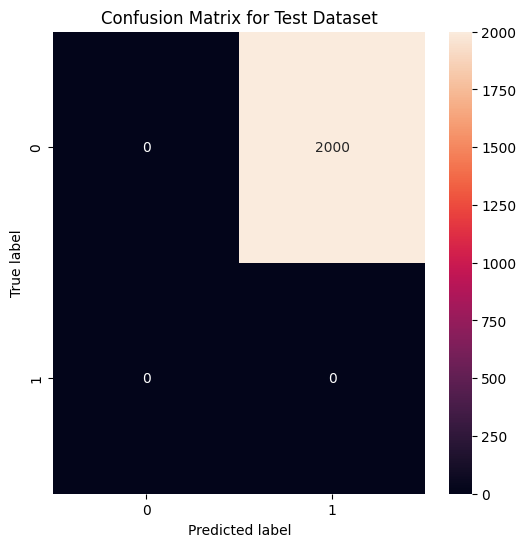

In [277]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define all possible classes
all_labels = [0, 1]

# Generate confusion matrix with all labels
cm = confusion_matrix(test_y, y_pred, labels=all_labels)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix for Test Dataset')
plt.show()


# Testing with SVM model

In [278]:
import os
import joblib

# Define directories (2 levels up -> Models/SVM)
model_dir = os.path.join("..", "..", "Models", "Baby Detection")

# Define file paths
model_path = os.path.join(model_dir, "svm_model_Baby_Detection.pkl")
scaler_path = os.path.join(model_dir, "svm_scaler_Baby_Detection.pkl")

# Load the trained SVM model
svm_model = joblib.load(model_path)

# Load the scaler
scaler = joblib.load(scaler_path)

print(f"Model loaded from: {os.path.abspath(model_path)}")
print(f"Scaler loaded from: {os.path.abspath(scaler_path)}")

# Ensure test dataset has the same features the model was trained on
if hasattr(scaler, "feature_names_in_"):
    test_x_dataset_1_reduced = test_x_dataset_1_reduced[scaler.feature_names_in_]

# Preprocess test data and predict
X_test_scaled = scaler.transform(test_x_dataset_1_reduced.values)
y_pred = svm_model.predict(X_test_scaled)
y_pred



Model loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Baby Detection/svm_model_Baby_Detection.pkl
Scaler loaded from: /Users/mandarkale/Documents/MyProjects/MachineLearning/FIUS_Based_Infant_Presence_Detection_in_Car_Seats/source_code/Models/Baby Detection/svm_scaler_Baby_Detection.pkl


array([1., 1., 1., ..., 1., 1., 1.], shape=(2000,))

In [279]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Optional: More detailed report
print("\nClassification Report:")
print(classification_report(test_y, y_pred,zero_division=0))

# Optional: Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(test_y, y_pred))


Accuracy: 0.0000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00    2000.0
         1.0       0.00      0.00      0.00       0.0

    accuracy                           0.00    2000.0
   macro avg       0.00      0.00      0.00    2000.0
weighted avg       0.00      0.00      0.00    2000.0


Confusion Matrix:
[[   0 2000]
 [   0    0]]


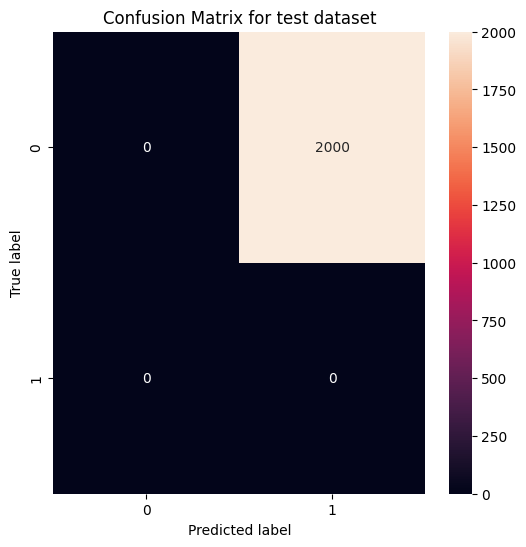

In [280]:
# Generate confusion matrix
cm = confusion_matrix(test_y, y_pred)
cm

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax)  # Use fmt='d' for integer annotation
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title('Confusion Matrix for test dataset')
plt.show()